### CLONE GITHUB WITH ENVIRONMENT IMAGES


In [ ]:
""" Clonando do GitHub as imagens do ambiente simulado """

! git clone https://github.com/BrunoDalI/ROS_Gazebo.git

Cloning into 'ROS_Gazebo'...
remote: Enumerating objects: 11318, done.
remote: Counting objects: 100% (1780/1780), done.
remote: Compressing objects: 100% (1775/1775), done.
remote: Total 11318 (delta 5), reused 1780 (delta 5), pack-reused 9538
Receiving objects: 100% (11318/11318), 438.69 MiB | 34.94 MiB/s, done.
Resolving deltas: 100% (242/242), done.
Checking out files: 100% (11567/11567), done.


### DRIVE FOLDER TO SAVE AND LOAD TRAINED MODELS


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### LIBRARIES IMPORTS

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import seaborn as sns
import pandas as pd
from keras.layers.pooling import GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

### GPU CONFIGURATION

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

### GLOBAL VARIABLES

In [ ]:
# Tamanho das imagens
image_width = 160
image_height = 160
image_color_channel = 3
#image_color_channel_size = 255
image_size = (image_width, image_height)
# Imagem RGB
image_shape = image_size + (image_color_channel,)


# Quantidade de imagens carregadas por vez
batch_size = 200
# Epocas que a cnn irá percorrer
epochs = 200
# Taxa de aprendizagem
learning_rate = 0.00001

# calsse = [0, 1]
class_names = ['cozinha', 'quarto', 'sala']

### DATASET CREATION

In [ ]:
# Criando dataset de treino e validação
# Creation of the train and validation dataset
dataset_dir = os.path.join(os.getcwd(), 'ROS_Gazebo')

dataset_train_dir = os.path.join(dataset_dir, 'House/Train')
dataset_train_cozinha_len = len(os.listdir(os.path.join(dataset_train_dir, 'cozinha')))
dataset_train_quarto_len = len(os.listdir(os.path.join(dataset_train_dir, 'quarto')))
dataset_train_sala_len = len(os.listdir(os.path.join(dataset_train_dir, 'sala')))

dataset_validation_dir = os.path.join(dataset_dir, 'House/Validation')
dataset_validation_cozinha_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cozinha')))
dataset_validation_quarto_len = len(os.listdir(os.path.join(dataset_validation_dir, 'quarto')))
dataset_validation_sala_len = len(os.listdir(os.path.join(dataset_validation_dir, 'sala')))


print('Train cozinha: %s' % dataset_train_cozinha_len)
print('Train quarto: %s' % dataset_train_quarto_len)
print('Train sala: %s' % dataset_train_sala_len)
print('Validation cozinha: %s' % dataset_validation_cozinha_len)
print('Validation quarto: %s' % dataset_validation_quarto_len)
print('Validation sala: %s' % dataset_validation_sala_len)

Train cozinha: 2382
Train quarto: 2472
Train sala: 2525
Validation cozinha: 850
Validation quarto: 850
Validation sala: 850
Unknown  cozinha: 543
Unknown  quarto: 553
Unknown sala: 541


In [ ]:
# Verifica a quantidade de imagens por classe do datase_train
# Checks the number of images per datase_train class
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 7379 files belonging to 3 classes.


In [ ]:
# Verifica a quantidade de imagens por classe do datase_validation
# Check the number of images per datase_validation class
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = (image_width, image_height),
    batch_size = batch_size,
    shuffle = True
)

Found 2550 files belonging to 3 classes.


In [ ]:
# Criando um dataset para validar o modelo que foi treinado
# Creating a dataset to validate the model that was trained
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 11
Test Dataset Cardinality: 2


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7379 files belonging to 3 classes.
Using 5904 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2550 files belonging to 3 classes.
Using 510 files for validation.


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### DATA AUGMENTATION

In [ ]:
# Para realizar rotação e mudança nas dimensões das imagens para melhorar a accurancy
# To perform rotation and change in dimensions of images to improve accurancy
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

In [ ]:
# Mostrar o resultado das imagens com aplicação do data_augmentation
# Show the result of images with application of the data_augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### CNN MODEL ARCHITECTURE

In [ ]:
inputs = keras.Input(shape=image_shape)
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./255)(x)
x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(128, 3, padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(128, 3, padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(18, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
output = tf.keras.layers.Dense(3, activation = 'sigmoid')(x)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                             

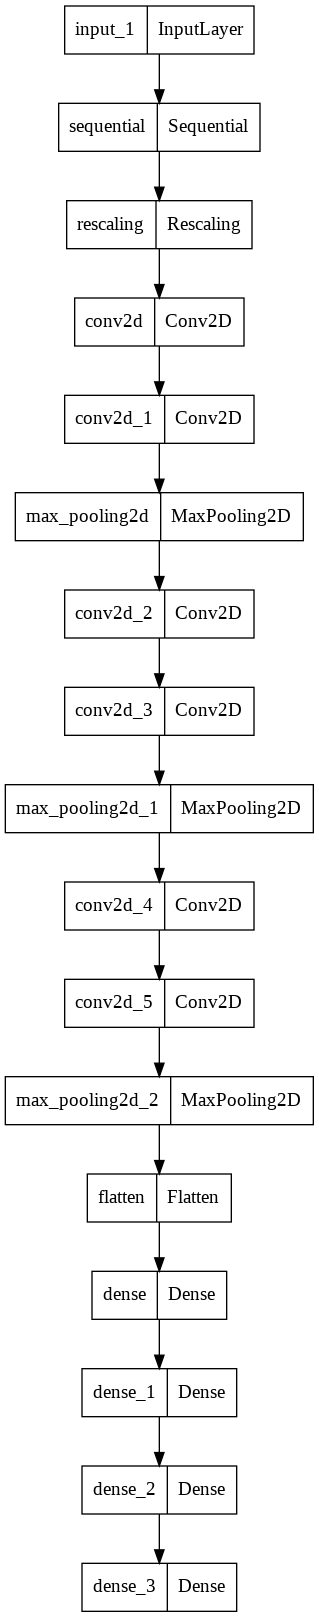

In [ ]:
# Salva modelo em um .png
tf.keras.utils.plot_model(model, to_file= 'model.png')

### MODEL FIT

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
               optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.99), metrics=['acc'])

In [ ]:

history = model.fit(
    train_ds, 
    epochs=epochs,
    validation_data = val_ds,
)

Epoch 1/200
30/30 [==============================] - 982s 33s/step - loss: 1.0102 - acc: 0.5344 - val_loss: 0.8659 - val_acc: 0.6255
Epoch 2/200
30/30 [==============================] - 979s 33s/step - loss: 0.7715 - acc: 0.6853 - val_loss: 0.6997 - val_acc: 0.7157
Epoch 3/200
30/30 [==============================] - 984s 33s/step - loss: 0.6599 - acc: 0.7364 - val_loss: 0.6771 - val_acc: 0.7706
Epoch 4/200
18/30 [=================>............] - ETA: 6:32 - loss: 0.6399 - acc: 0.7378

### MODEL EVALUATION

In [ ]:
""" Clonando do GitHub as imagens do ambiente simulado """

! git clone https://github.com/BrunoDalI/ROS_Gazebo2.git

In [ ]:
dataset_dir = os.path.join(os.getcwd(), 'ROS_Gazebo')
dataset_unknown_dir = os.path.join(dataset_dir, 'House/Unknown')
dataset_unknown_cozinha_len = len(os.listdir(os.path.join(dataset_unknown_dir, 'cozinha')))
dataset_unknown_quarto_len = len(os.listdir(os.path.join(dataset_unknown_dir, 'quarto')))
dataset_unknown_sala_len = len(os.listdir(os.path.join(dataset_unknown_dir, 'sala')))

print('Unknown  cozinha: %s' % dataset_unknown_cozinha_len)
print('Unknown  quarto: %s' % dataset_unknown_quarto_len)
print('Unknown sala: %s' % dataset_unknown_sala_len)

In [ ]:
# Criando um dataset para validar o modelo que foi treinado
# Creating a dataset to validate the model that was trained
dataset_unknown_cardinality = tf.data.experimental.cardinality(dataset_unknown)
dataset_unknown_batches = dataset_unknown_cardinality // 5

dataset_test = dataset_unknown.take(dataset_unknown_batches)
dataset_unknown = dataset_unknown.skip(dataset_unknown_batches)

print('Unknown Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_unknown))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))

In [ ]:
# Avaliação do modelo utilizado
# Evaluation of the model used
dataset_test_loss, dataset_test_accuracy = model.evaluate(dataset_test)

print('Dataset Test Loss:     %s' % dataset_test_loss)
print('Dataset Test Accuracy: %s' % dataset_test_accuracy)

In [ ]:
# Função para avaliar a rede cnn
def plot_model():
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()

In [ ]:
# Chamada e verificação da avaliação da cnn aplicada
plot_model()

### SAVE MODEL

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Save_Models/model1_acc{dataset_test_accuracy}')

### LOAD MODEL

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Save_Models/model1_acc0.9950000047683716')

In [ ]:
# Avaliação do modelo utilizado
# Evaluation of the model used
dataset_test_loss, dataset_test_accuracy = model.evaluate(dataset_test)

print('Dataset Test Loss:     %s' % dataset_test_loss)
print('Dataset Test Accuracy: %s' % dataset_test_accuracy)

2/2 [==============================] - 18s 7s/step - loss: 0.0162 - acc: 0.9950
Dataset Test Loss:     0.016208907589316368
Dataset Test Accuracy: 0.9950000047683716


### PREDICTIONS

### GET LABELS

In [ ]:
features, labels = dataset_test.as_numpy_iterator().next()
features.shape

In [ ]:
labels.shape

In [ ]:
predictions = model.predict(features)
predictions.shape

### CONFUSION MATRIX

In [ ]:
# Função que mostra o gráfico de matriz de confusão
# Function that shows the confusion matrix graph
def confusion_matrix_plot(y, y_pred, dataset='Test'):
  cm = tf.math.confusion_matrix( y, y_pred).numpy()
  df_cm = pd.DataFrame(cm, index = [i for i in ["cozinha","quarto", "sala"]],
                columns = [i for i in ["Predict cozinha","Predict quarto", "Predict sala"]])
  group_counts = ["{0:0.0f}".format(value) for value in
              cm.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(3,3)
  plt.figure(figsize = (10,6))
  sns.heatmap(df_cm, annot=labels,fmt='', cmap='crest')
  plt.ylabel('\nTrue label\n', fontsize=14, fontweight='bold')
  plt.xlabel('\nPredicted label\n', fontsize=14, fontweight='bold')
  plt.title(f'\n{dataset} Confusion Matrix\n', fontsize=20, fontweight='bold')

In [ ]:
predictions

In [ ]:
np.argmax(predictions, axis=1)

array([1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 2, 1, 0, 1, 1, 0, 1, 0, 0, 1, 2, 2, 2, 1, 0, 2,
       0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 2, 2, 1, 0, 2, 1, 2, 0, 0, 2, 0,
       1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 2, 1, 0,
       0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1,
       2, 0, 1, 2, 0, 0, 2, 2, 1, 0, 0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 0, 0, 2, 2, 1, 2, 0, 1, 0, 1, 1, 2, 0, 2, 2, 2, 0, 0,
       1, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 2, 0, 2, 1, 1, 2,
       2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1,
       2, 2])

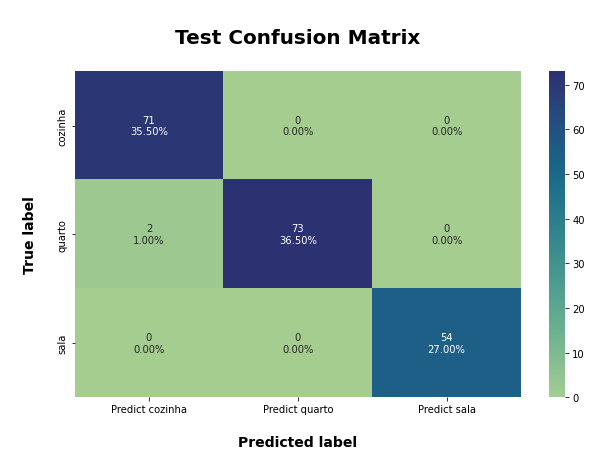

In [ ]:
confusion_matrix_plot(labels,np.argmax(predictions, axis=1))

In [ ]:
def ambiente(b):
  a = b[23:24]
  if a == '1':
    a = 'Cozinha'
  elif a == '2':
    a = 'Quarto'
  elif a == '3':
    a = 'Sala'
  return a

In [ ]:
def predict(image_file):
    amb = ambiente(image_file)
    image = tf.keras.preprocessing.image.load_img(image_file, target_size = image_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)

    prediction = model.predict(image)[0][0]
    print('Prediction: {0} | {1}'.format(prediction, amb if prediction > 0.5 else 'Não é', amb))

In [ ]:
predict("C:/Users/Diogo/Desktop/1.jpg")   